In [1]:
import open3d as o3d
import numpy as np
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# RGBD integration
Open3D implements a scalable RGBD image integration algorithm. The algorithm is based on the technique presented in [\[Curless1996\]](../reference.html#curless1996) and [\[Newcombe2011\]](../reference.html#newcombe2011). In order to support large scenes, we use a hierarchical hashing structure introduced in [Integrater in ElasticReconstruction](https://github.com/qianyizh/ElasticReconstruction/tree/master/Integrate).

## Read trajectory from .log file
This tutorial uses the function `read_trajectory` to read a camera trajectory from a [.log file](http://redwood-data.org/indoor/fileformat.html). A sample `.log` file is as follows.

```
# test_data/RGBD/odometry.log
0   0   1
1   0   0   2
0   1   0   2
0   0   1 -0.3
0   0   0   1
1   1   2
0.999988  3.08668e-005  0.0049181  1.99962
-8.84184e-005  0.999932  0.0117022  1.97704
-0.0049174  -0.0117024  0.999919  -0.300486
0  0  0  1
```

In [2]:
class CameraPose:

    def __init__(self, meta, mat):
        self.metadata = meta
        self.pose = mat

    def __str__(self):
        return 'Metadata : ' + ' '.join(map(str, self.metadata)) + '\n' + \
            "Pose : " + "\n" + np.array_str(self.pose)


def read_trajectory(filename):
    traj = []
    with open(filename, 'r') as f:
        metastr = f.readline()
        while metastr:
            metadata = list(map(int, metastr.split()))
            mat = np.zeros(shape=(4, 4))
            for i in range(4):
                matstr = f.readline()
                mat[i, :] = np.fromstring(matstr, dtype=float, sep=' \t')
            traj.append(CameraPose(metadata, mat))
            metastr = f.readline()
    return traj

In [3]:
camera_poses = read_trajectory(o3dtut.get_data_path_common("RGBD/odometry.log"))

## TSDF volume integration
Open3D provides two types of TSDF volumes: `UniformTSDFVolume` and `ScalableTSDFVolume`. The latter is recommended since it uses a hierarchical structure and thus supports larger scenes.

`ScalableTSDFVolume` has several parameters. `voxel_length = 4.0 / 512.0` means a single voxel size for TSDF volume is $\frac{4.0\mathrm{m}}{512.0} = 7.8125\mathrm{mm}$. Lowering this value makes a high-resolution TSDF volume, but the integration result can be susceptible to depth noise. `sdf_trunc = 0.04` specifies the truncation value for the signed distance function (SDF). When `color_type = TSDFVolumeColorType.RGB8`, 8 bit RGB color is also integrated as part of the TSDF volume. Float type intensity can be integrated with `color_type = TSDFVolumeColorType.Gray32` and `convert_rgb_to_intensity = True`. The color integration is inspired by [PCL](http://pointclouds.org/).

In [4]:
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

for i in range(len(camera_poses)):
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(
        o3dtut.get_data_path_common("RGBD/color/{:05d}.jpg".format(i)))
    depth = o3d.io.read_image(
        o3dtut.get_data_path_common("RGBD/depth/{:05d}.png".format(i)))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    volume.integrate(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault),
        np.linalg.inv(camera_poses[i].pose))

Integrate 0-th image into the volume.
Integrate 1-th image into the volume.
Integrate 2-th image into the volume.
Integrate 3-th image into the volume.
Integrate 4-th image into the volume.


## Extract a mesh
Mesh extraction uses the marching cubes algorithm [\[LorensenAndCline1987\]](../reference.html#lorensenandcline1987).

Extract a triangle mesh from the volume and visualize it.


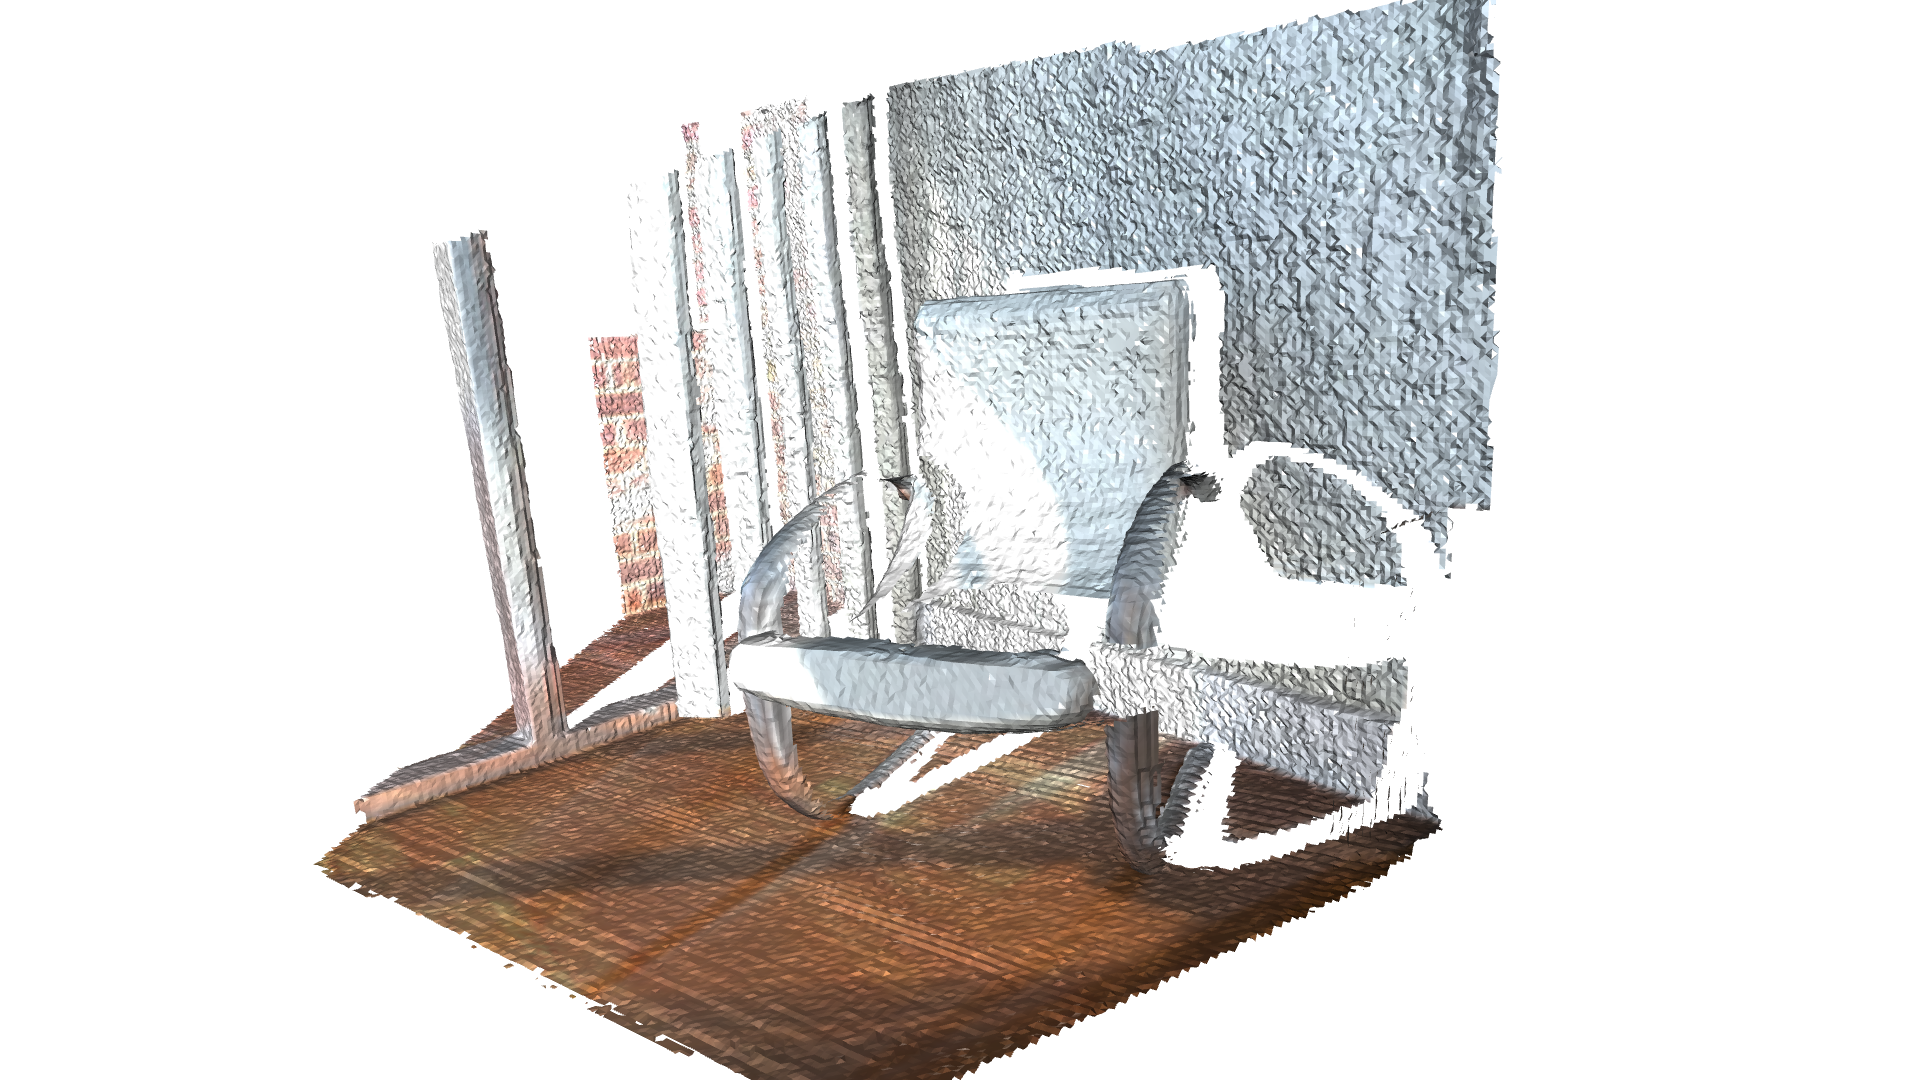

In [5]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh],
                                  front=[0.5297, -0.1873, -0.8272],
                                  lookat=[2.0712, 2.0312, 1.7251],
                                  up=[-0.0558, -0.9809, 0.1864],
                                  zoom=0.47)

<div class="alert alert-info">
    
**Note:**

TSDF volume works like a weighted average filter in 3D space. If more frames are integrated, the volume produces a smoother and nicer mesh. Please check [Make fragments](../reconstruction_system/make_fragments.rst) for more examples.

</div>